<a href="https://colab.research.google.com/github/adarithanmayee26/loan-prediction-/blob/main/loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import joblib


In [2]:
import pandas as pd

df = pd.read_csv("loan_applications.csv")
print(df.shape)
df.head()


(50000, 21)


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


In [3]:
df.info()
df['fraud_flag'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   application_id             50000 non-null  object 
 1   customer_id                50000 non-null  object 
 2   application_date           50000 non-null  object 
 3   loan_type                  50000 non-null  object 
 4   loan_amount_requested      50000 non-null  float64
 5   loan_tenure_months         50000 non-null  int64  
 6   interest_rate_offered      50000 non-null  float64
 7   purpose_of_loan            50000 non-null  object 
 8   employment_status          50000 non-null  object 
 9   monthly_income             50000 non-null  float64
 10  cibil_score                50000 non-null  int64  
 11  existing_emis_monthly      50000 non-null  float64
 12  debt_to_income_ratio       50000 non-null  float64
 13  property_ownership_status  50000 non-null  obj

,count
fraud_flag,
0,48974
1,1026


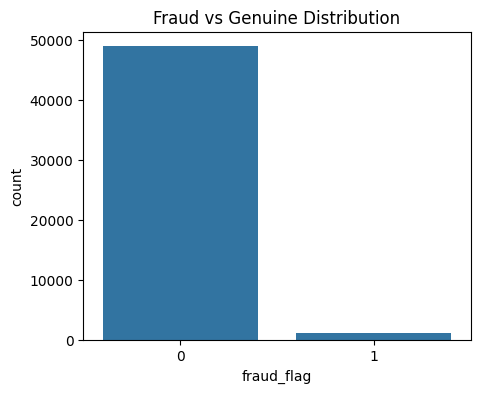

fraud_flag
0    48974
1     1026
Name: count, dtype: int64


In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x="fraud_flag", data=df)
plt.title("Fraud vs Genuine Distribution")
plt.show()

print(df["fraud_flag"].value_counts())

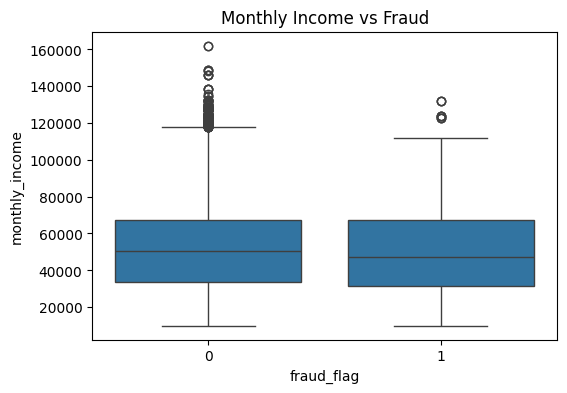

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x="fraud_flag", y="monthly_income", data=df)
plt.title("Monthly Income vs Fraud")
plt.show()

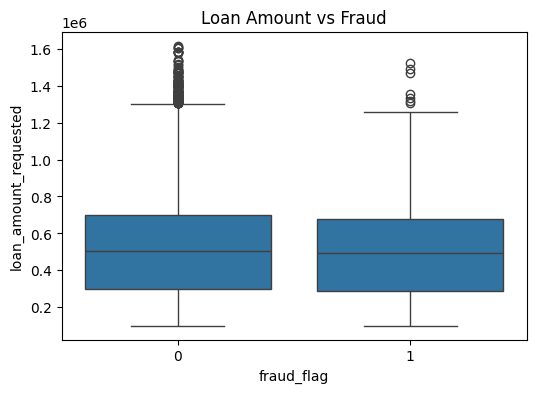

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x="fraud_flag", y="loan_amount_requested", data=df)
plt.title("Loan Amount vs Fraud")
plt.show()


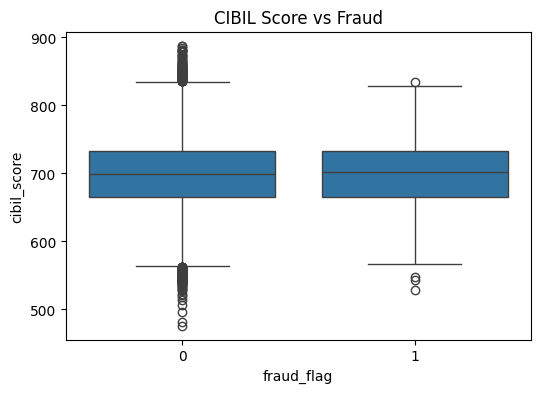

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x="fraud_flag", y="cibil_score", data=df)
plt.title("CIBIL Score vs Fraud")
plt.show()

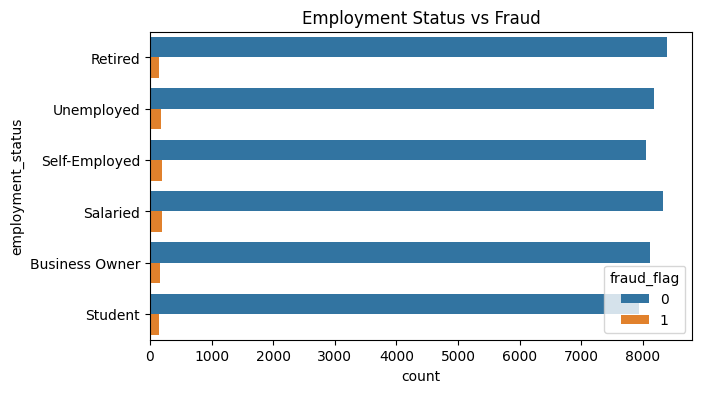

In [12]:
plt.figure(figsize=(7,4))
sns.countplot(y="employment_status", hue="fraud_flag", data=df)
plt.title("Employment Status vs Fraud")
plt.show()

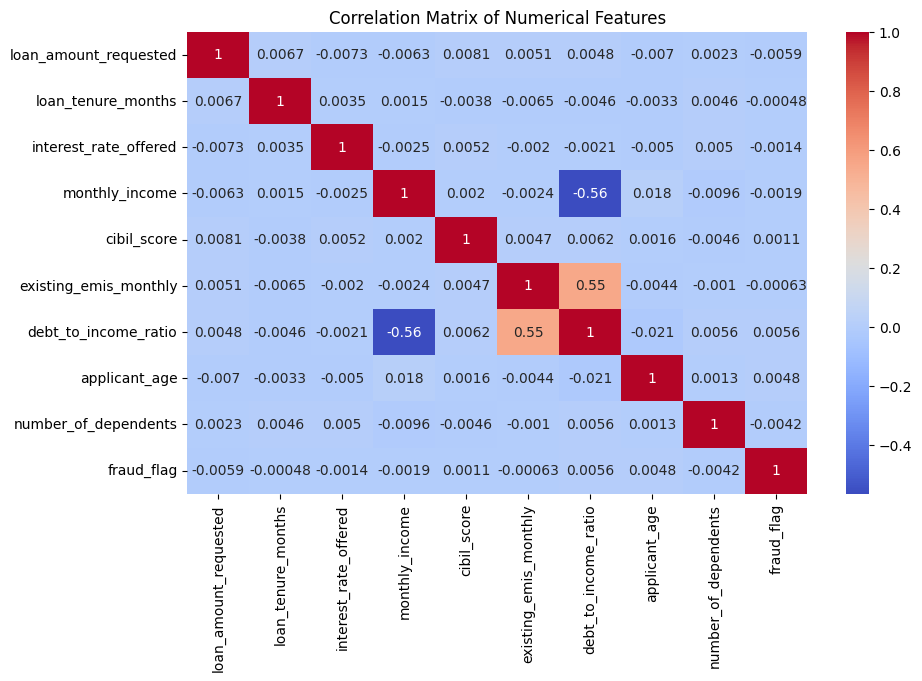

In [13]:
numeric_df = df.select_dtypes(include=["int64","float64"])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [14]:
drop_cols = [
    "application_id",
    "customer_id",
    "residential_address",
    "application_date",
    "fraud_type",
    "loan_status"

]

df = df.drop(columns=drop_cols)

In [15]:
X = df.drop("fraud_flag", axis=1)
y = df["fraud_flag"]


In [16]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


print("Numerical Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))

Numerical Columns: ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 'applicant_age', 'number_of_dependents']
Categorical Columns: ['loan_type', 'purpose_of_loan', 'employment_status', 'property_ownership_status', 'gender']


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_prep = preprocessor.fit_transform(X)


In [18]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_prep, y)

print("After SMOTE class distribution:")
print(pd.Series(y_bal).value_counts())

After SMOTE class distribution:
fraud_flag
0    48974
1    48974
Name: count, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal,
    y_bal,
    test_size=0.2,
    stratify=y_bal,
    random_state=42
)


In [26]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=42)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
y_pred = rf.predict(X_test)


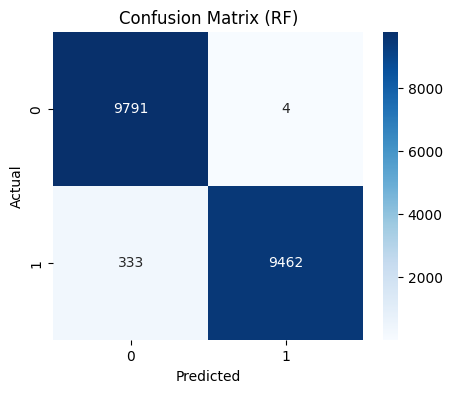

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (RF)")
plt.show()

In [29]:
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

# print("ROC AUC:", roc_auc_score(y_test, y_prob))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9795
           1       1.00      0.97      0.98      9795

    accuracy                           0.98     19590
   macro avg       0.98      0.98      0.98     19590
weighted avg       0.98      0.98      0.98     19590



In [30]:
gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    class_weight={0: 1, 1: 8},
    random_state=42
)
gb.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight={0: 1, 1: 8}, learning_rate=0.05,
                               max_depth=6, random_state=42)

In [31]:
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance",   # IMPORTANT for fraud
    metric="euclidean"
)
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')

In [32]:
ensemble = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("gb", gb),
        ("knn", knn)
    ],
    voting="soft",
    weights=[2, 2, 1]   # KNN slightly lower weight
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=12,
                                                     random_state=42)),
                             ('gb',
                              HistGradientBoostingClassifier(class_weight={0: 1,
                                                                           1: 8},
                                                             learning_rate=0.05,
                                                             max_depth=6,
                                                             random_state=42)),
                             ('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=7,
                                                   weights='distance'))],
                 voting='soft', weights=[2, 2, 1])

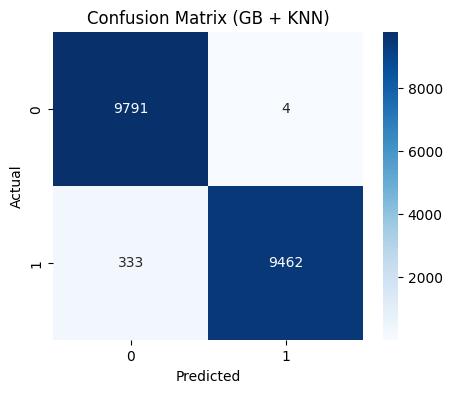

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GB + KNN)")
plt.show()

ROC AUC: 0.9948333902687587


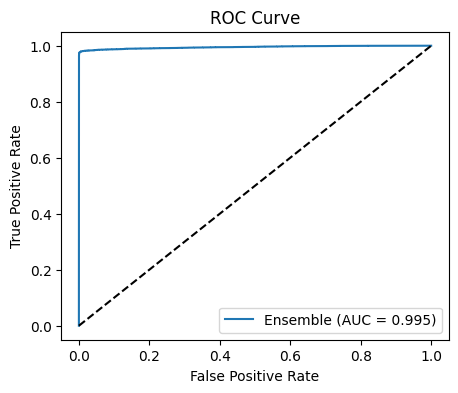

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get probabilities
y_prob = rf.predict_proba(X_test)[:, 1]

THRESHOLD = 0.5   # try 0.35–0.45 if needed
y_pred = (y_prob >= THRESHOLD).astype(int)

print("ROC AUC:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label="Ensemble (AUC = {:.3f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [37]:
joblib.dump(ensemble, "loan_fraud_ensemble_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

print("Model and preprocessor saved successfully.")

Model and preprocessor saved successfully.


In [38]:
import gradio as gr
import pandas as pd
import joblib
import random

# --------------------------------------------------
# Load trained model and preprocessor
# --------------------------------------------------
model = joblib.load("loan_fraud_ensemble_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")

# --------------------------------------------------
# Random data generator
# --------------------------------------------------
def generate_random_inputs():
    return (
        random.choice(["Home Loan", "Personal Loan", "Car Loan", "Education Loan"]),
        random.randint(50000, 5000000),          # loan amount
        random.randint(6, 360),                  # tenure
        round(random.uniform(7.0, 18.0), 2),     # interest rate
        random.choice(["Education", "Medical", "Business", "Travel", "Other"]),
        random.choice(["Salaried", "Self-Employed", "Business Owner", "Student", "Unemployed", "Retired"]),
        random.randint(10000, 200000),            # income
        random.randint(300, 900),                 # CIBIL
        random.randint(0, 50000),                 # EMIs
        round(random.uniform(0.1, 0.9), 2),       # DTI
        random.choice(["Owned", "Rented", "Family"]),
        random.randint(18, 70),                   # age
        random.choice(["Male", "Female", "Other"]),
        random.randint(0, 5)                      # dependents
    )

# --------------------------------------------------
# Prediction function
# --------------------------------------------------
def predict_fraud(
    loan_type,
    loan_amount_requested,
    loan_tenure_months,
    interest_rate_offered,
    purpose_of_loan,
    employment_status,
    monthly_income,
    cibil_score,
    existing_emis_monthly,
    debt_to_income_ratio,
    property_ownership_status,
    applicant_age,
    gender,
    number_of_dependents
):
    input_df = pd.DataFrame([{
        "loan_type": loan_type,
        "loan_amount_requested": loan_amount_requested,
        "loan_tenure_months": loan_tenure_months,
        "interest_rate_offered": interest_rate_offered,
        "purpose_of_loan": purpose_of_loan,
        "employment_status": employment_status,
        "monthly_income": monthly_income,
        "cibil_score": cibil_score,
        "existing_emis_monthly": existing_emis_monthly,
        "debt_to_income_ratio": debt_to_income_ratio,
        "property_ownership_status": property_ownership_status,
        "applicant_age": applicant_age,
        "gender": gender,
        "number_of_dependents": number_of_dependents
    }])

    X_processed = preprocessor.transform(input_df)
    fraud_prob = model.predict_proba(X_processed)[0][1]

    prediction = "FRAUD 🚨" if fraud_prob >= 0.4 else "GENUINE ✅"
    return prediction, round(fraud_prob, 3)

# --------------------------------------------------
# Gradio UI
# --------------------------------------------------
with gr.Blocks(title="🏦 Loan Fraud Detection System") as app:

    gr.Markdown("## 🏦 Loan Fraud Detection System")
    gr.Markdown("Click **Generate Random Application** to auto-fill values and predict fraud.")

    loan_type = gr.Dropdown(["Home Loan", "Personal Loan", "Car Loan", "Education Loan"], label="Loan Type")
    loan_amount = gr.Number(label="Loan Amount Requested")
    tenure = gr.Number(label="Loan Tenure (Months)")
    interest = gr.Number(label="Interest Rate Offered (%)")
    purpose = gr.Dropdown(["Education", "Medical", "Business", "Travel", "Other"], label="Purpose of Loan")
    employment = gr.Dropdown(
        ["Salaried", "Self-Employed", "Business Owner", "Student", "Unemployed", "Retired"],
        label="Employment Status"
    )
    income = gr.Number(label="Monthly Income")
    cibil = gr.Number(label="CIBIL Score")
    emis = gr.Number(label="Existing EMIs (Monthly)")
    dti = gr.Number(label="Debt-to-Income Ratio")
    property_status = gr.Dropdown(["Owned", "Rented", "Family"], label="Property Ownership")
    age = gr.Number(label="Applicant Age")
    gender = gr.Dropdown(["Male", "Female", "Other"], label="Gender")
    dependents = gr.Number(label="Number of Dependents")

    generate_btn = gr.Button("🎲 Generate Random Application")
    predict_btn = gr.Button("🔍 Predict Fraud")

    output_pred = gr.Textbox(label="Prediction")
    output_prob = gr.Number(label="Fraud Probability")

    generate_btn.click(
        generate_random_inputs,
        outputs=[
            loan_type, loan_amount, tenure, interest, purpose, employment,
            income, cibil, emis, dti, property_status, age, gender, dependents
        ]
    )

    predict_btn.click(
        predict_fraud,
        inputs=[
            loan_type, loan_amount, tenure, interest, purpose, employment,
            income, cibil, emis, dti, property_status, age, gender, dependents
        ],
        outputs=[output_pred, output_prob]
    )

app.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d5aba76ab0471d4060.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d5aba76ab0471d4060.gradio.live
